# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [0]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [66]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### 1.Set your project path where you have your data and related files for this lab.

In [0]:
project_path = "/content/drive/My Drive/Unet/"

### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =        
path_train = project_path + 'train/'   #Path for your train data

In [0]:
import os
os.chdir('/content/drive/My Drive/Unet/')

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [70]:
!mkdir '/content/drive/My Drive/Unet/train'

mkdir: cannot create directory ‘/content/drive/My Drive/Unet/train’: File exists


# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
  zf.extractall('train/')


In [0]:
#The train file have both images and masks with the same names_ids.

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [0]:
imagelist = os.listdir('/content/drive/My Drive/Unet/train/images')
masklist = os.listdir('/content/drive/My Drive/Unet/train/masks')

In [74]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

7cc53fe88b.png
7cc53fe88b.png
de08c5a3b7.png
de08c5a3b7.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


In [0]:
import  matplotlib.pyplot as plt
import cv2

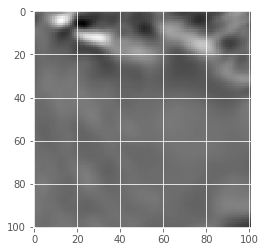

In [76]:
plt.imshow(cv2.imread('/content/drive/My Drive/Unet/train/images/{}'.format(imagelist[10])))

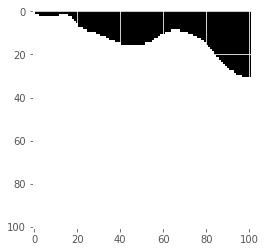

In [77]:
plt.imshow(cv2.imread('/content/drive/My Drive/Unet/train/masks/{}'.format(masklist[10])))

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [78]:
# Get and resize train images and masks
def get_data(train=True):
    #ids = next(os.walk("train/images"))[2]
    X = np.zeros((len(imagelist), im_height, im_width, 1), dtype=np.float32)
    y = np.zeros((len(masklist), im_height, im_width, 1), dtype=np.float32)
    for n in imagelist:
        k = imagelist.index(n)
        image_path = os.path.join(project_path +'train/images/'+n )
        mask_path = os.path.join(project_path +'train/masks/'+n )
        
        # Load images
        img = cv2.imread(image_path, 0)
        resized_img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
        

        # Load masks
        if train:
            mask = cv2.imread(mask_path, 0)
            resized_mask = cv2.resize(mask, (128, 128), interpolation = cv2.INTER_AREA)
            resized_mask = np.reshape(resized_mask, (128,128,1))
            
           

        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        if train:
            y[k] = resized_mask/255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train=True)

Done!


In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

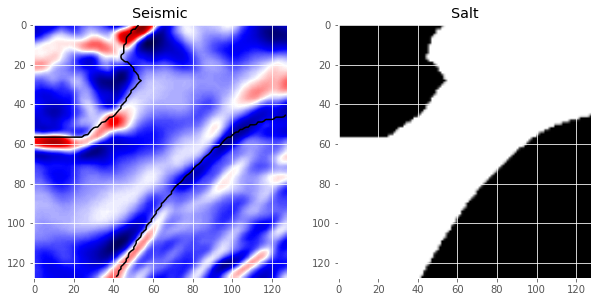

In [80]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');




### 8. Define loss and dice_coeff function.

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [0]:
from keras.losses import binary_crossentropy
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [83]:
!pip install segmentation-models

In [0]:
#Import libraries
from segmentation_models import Unet
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from keras.layers import Input, Conv2D, Reshape
from keras.models import Model

In [0]:
#model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))
#compile your model by adding the parameters like optimizer, loss and metrics.

model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))

In [0]:
model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])

In [87]:
#Get the summary of your model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 1 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 1 3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_69 (ZeroPadding2 (None, None, None, 1 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 3136        zero_padding2d_69[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [88]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=16,    
    epochs=2,
    validation_data=(X_valid, y_valid)
)

Train on 3400 samples, validate on 600 samples
Epoch 1/2
3400/3400 [==============================] - 1460s 429ms/step - loss: 1.0739 - dice_coefficient: 0.5645 - val_loss: 1.2074 - val_dice_coefficient: 0.6094
Epoch 2/2
3400/3400 [==============================] - 1454s 428ms/step - loss: 0.7957 - dice_coefficient: 0.6665 - val_loss: 2.0258 - val_dice_coefficient: 0.5822


### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [89]:
preds_val = model.predict(X_valid, verbose=1)

600/600 [==============================] - 63s 104ms/step


In [0]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

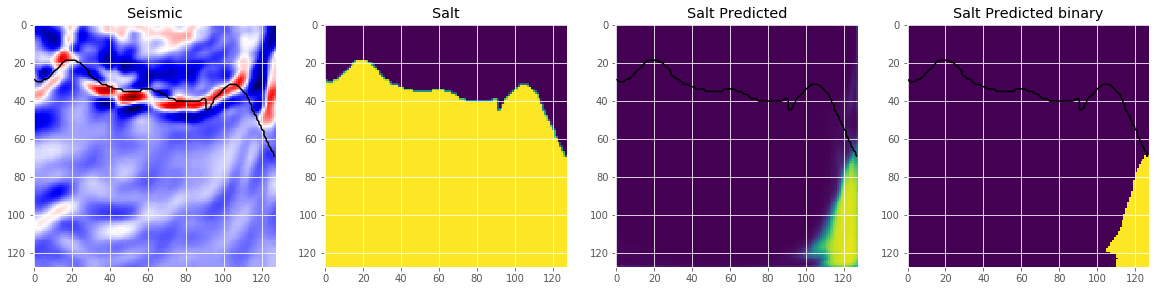

In [92]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

In [93]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/NLP/data')

### Import Keras and other libraries

In [0]:
import glob

from sklearn.utils import shuffle
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam
from keras import backend

## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [0]:
filelist = glob.glob("/content/drive/My Drive/NLP/data/*.txt")

### Read the data

Read contents of every file from the list and append the text in a new list

In [0]:
text_data = []
for file in filelist:
    with open(file, "r") as file:
      text_data.append(file.read())

## Process the text
Initialize and fit the tokenizer

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [0]:
word_idx = tokenizer.word_index #Last is the key
idx_word = tokenizer.index_word

Get the word count for every word and also get the total number of words.

In [0]:
word_counts = tokenizer.word_counts
num_words = len(word_counts)

In [102]:
print(num_words)

14787


Convert text to sequence of numbers

In [0]:
sequences = tokenizer.texts_to_sequences(text_data)

### Generate Features and Labels

In [0]:
features = []
labels = []

training_length = 50
# Iterate through the sequences of tokens
for seq in sequences:
    # Create multiple training examples from each sequence
    for i in range(training_length, training_length+300):
        # Extract the features and label
        extract = seq[i - training_length: i - training_length + 20]

        # Set the features and label
        features.append(extract[:-1])
        labels.append(extract[-1])

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

In [0]:
from sklearn.utils import shuffle
import numpy as np

features, labels = shuffle(features, labels, random_state=1)

# Decide on number of samples for training
train_end = int(0.75 * len(labels))

train_features = np.array(features[:train_end])
valid_features = np.array(features[train_end:])

train_labels = labels[:train_end]
valid_labels = labels[train_end:]

# Convert to arrays
X_train, X_valid = np.array(train_features), np.array(valid_features)

# Using int8 for memory savings
y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

# One hot encoding of labels
for example_index, word_index in enumerate(train_labels):
    y_train[example_index, word_index] = 1

for example_index, word_index in enumerate(valid_labels):
    y_valid[example_index, word_index] = 1

This is just to check the features and labels

In [106]:
for i, sequence in enumerate(X_train[:1]):
    text = []
    for idx in sequence:
        text.append(idx_word[idx])
        
    print('Features: ' + ' '.join(text)+'\n')
    print('Label: ' + idx_word[np.argmax(y_train[i])] + '\n')

Features: influence of the impressionists on climate an exposure to naturalism thomas griffiths wainewright wainewright at hobart town cardinal newman

Label: and



## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [107]:
model = Sequential()

# Embedding layer
model.add(
    Embedding(
        input_dim=num_words,
        output_dim=100,
        weights=None,
        trainable=True))

# Recurrent layer
model.add(
    LSTM(
        64, return_sequences=False, dropout=0.1,
        recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_words, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

W0811 15:19:32.929295 140607297980288 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1478700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 14787)             961155    
Total params: 2,486,255
Trainable params: 2,486,255
Non-trainable params: 0
_________________________________________________________________


For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [108]:
h = model.fit(X_train, y_train, epochs = 1, batch_size = 500, verbose = 1)

Epoch 1/1
2250/2250 [==============================] - 7s 3ms/step - loss: 9.5994 - acc: 0.0089


### Save Model

In [0]:
model.save('/content/drive/My Drive/NLP/data/model_1000epochs.h5')

## If you have already trained the model and saved it, you can load a pretrained model

In [0]:
model = load_model('/content/drive/My Drive/NLP/data/model_1000epochs.h5')

### Note: After loading the model run  model.fit()  to continue training form there, if required.

In [112]:
model.fit(X_train, y_train, batch_size=50, epochs=500)

Epoch 1/500
2250/2250 [==============================] - 5s 2ms/step - loss: 8.5924 - acc: 0.0569
Epoch 2/500
2250/2250 [==============================] - 4s 2ms/step - loss: 6.6905 - acc: 0.0702
Epoch 3/500
2250/2250 [==============================] - 4s 2ms/step - loss: 6.4246 - acc: 0.0724
Epoch 4/500
2250/2250 [==============================] - 4s 2ms/step - loss: 6.2666 - acc: 0.0729
Epoch 5/500
2250/2250 [==============================] - 4s 2ms/step - loss: 6.1439 - acc: 0.0729
Epoch 6/500
2250/2250 [==============================] - 4s 2ms/step - loss: 6.0545 - acc: 0.0729
Epoch 7/500
2250/2250 [==============================] - 4s 2ms/step - loss: 5.9672 - acc: 0.0702
Epoch 8/500
2250/2250 [==============================] - 4s 2ms/step - loss: 5.9056 - acc: 0.0729
Epoch 9/500
2250/2250 [==============================] - 4s 2ms/step - loss: 5.8534 - acc: 0.0702
Epoch 10/500
2250/2250 [==============================] - 4s 2ms/step - loss: 5.7990 - acc: 0.0720
Epoch 11/500
2250/2

## Evaluation

In [113]:
print(model.evaluate(X_train, y_train, batch_size = 20))
print('\nModel Performance: Log Loss and Accuracy on validation data')
print(model.evaluate(X_valid, y_valid, batch_size = 20))

2250/2250 [==============================] - 3s 1ms/step
[0.009565313935745508, 0.9955555544959174]

Model Performance: Log Loss and Accuracy on validation data
750/750 [==============================] - 0s 534us/step
[10.280761171976724, 0.3000000027815501]


## Generate text

In [0]:
seed_length=50
new_words=50
diversity=1
n_gen=1

import random

# Choose a random sequence
seq = random.choice(sequences)

# print seq

# Choose a random starting point
seed_idx = random.randint(0, len(seq) - seed_length - 10)
# Ending index for seed
end_idx = seed_idx + seed_length

In [0]:
gen_list = []

for n in range(n_gen):
    # Extract the seed sequence
    seed = seq[seed_idx:end_idx]
    original_sequence = [idx_word[i] for i in seed]
    generated = seed[:] + ['#']

    # Find the actual entire sequence
    actual = generated[:] + seq[end_idx:end_idx + new_words]
        
    # Keep adding new words
    for i in range(new_words):

        # Make a prediction from the seed
        preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)
        exp_preds = np.exp(preds)

  
        # Softmax
        preds = exp_preds / sum(exp_preds)

        # Choose the next word
        probas = np.random.multinomial(1, preds, 1)[0]

        next_idx = np.argmax(probas)

        # New seed adds on old word
        #             seed = seed[1:] + [next_idx]
        seed += [next_idx]
        generated.append(next_idx)
    # Showing generated and actual abstract
    n = []

    for i in generated:
        n.append(idx_word.get(i, '< --- >'))

    gen_list.append(n)


In [122]:
a = []

for i in actual:
    a.append(idx_word.get(i, '< --- >'))

a = a[seed_length:]

gen_list = [gen[seed_length:seed_length + len(a)] for gen in gen_list]

print('Sequence: \n'+' '.join(original_sequence))

Sequence: 
till i have learned your secret runs laughing into the corridor guido oh horrible had i so soon forgot my father’s death did i so soon let love into my heart and must i banish love and let in murder that beats and clamours at the outer gate ay that


## Time Series Analysis using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temperature values to "Temperature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temperature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

### Import required libraries

#### Mount google drive

### Load the  data file

### Plot the data

### Check for null values and treat them

#### Drop null values (if any)

### Get the representation of the distribution of data in the form of histogram

### Check the maximum and minimum values

### Normalize the data

### Check the maximum and minimum values of scaled data

### Split data into Training and Testing set 
<u>Note</u> The train and test data has to be sequential. Keep the first 70% of data in training and the bottom 30% in test data 

## Create the sequential data
Map the temperature at a particular time t to the temperature at time t+n, where n is any number you define.

For example: to map temperatures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

### Use function to get training and test set

### Transform the prepared train and test input data into the expected structure using numpy.reshape()

### Define sequntial model, add LSTM layer and compile the model

### Train the model for 100 epochs with batch size = 1

### Make Predictions and Evaluate your model

In [94]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)

model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

NameError: ignored